<a href="https://colab.research.google.com/github/CFathurrohman/Machine_learning/blob/main/Kuis/Kuis_1_Labeled_Face_in_Wild.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kelompok 1
Anggota:
1. Cindy Vira Safitri  	          NIM. 2241720046
2. Cyndu Fathur Rohman  	        NIM. 2241720068
3. Raihan Fazzaufa Rasendriya    	NIM. 2241720201
4. Stefanus Ageng Budi Utomo    	NIM. 2241720126


# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Labeled Face in Wild (LFW).
Spesifikasi pengerjaan kuis yang harus dipehuni adalah,

1. Setiap label dari dataset LFW harus berisikan minimal 10 gambar (5 poin)
2. Citra yang digunakan merupakan citra RGB / color (5 poin)
3. (Opsional) Lakukan proses pra pengolahan data jika diperlukan (ekstra 10 poin)
4. (Wajib) Gunakan fitur histogram untuk setiap channel citra (35 poin)
5. (Wajib) Gunakan algoritma SVM sebagai model dasar (35 poin)
6. (Wajib) Gunakan metric akurasi, dan *classification report* untuk melihat performa model (20 poin)
7. (Wajib) Lakukan Interpretasi hasil klasifikasi terhadap permasalahan masing-masing kelompok

## Challenge
Setelah menyelesaikan kuis berdasarkan spesifikasi wajib, Anda diperkenankan untuk

- Menggunakan fitur lain selain histogram (ekstra 20 poin)
- Menggunakan model lain selain SVM (ekstra 10 poin)
- Evalusi dengan metric lain ataupun report dengan *confusion matrix* (ekstra 10 poin)

## Pengumpulan
- Ketua kelas membuat GDrive
- Masing-masing kelompok mengirimkan link Google Colabs pada GDrive tersebut
- Batas Pengumpulan **22 Oktober 2024 Pukul 15.00 WIB**

# Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis.
Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

---

# Preparation

In [ ]:
# Load required library
# Import Required Library
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import cv2 as cv
from skimage.feature import hog

# Load Data

In [ ]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
faces = fetch_lfw_people(min_faces_per_person=50, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 12
Data dimension: (1560, 62, 47, 3)
Images flatten dimension: (1560, 8742)


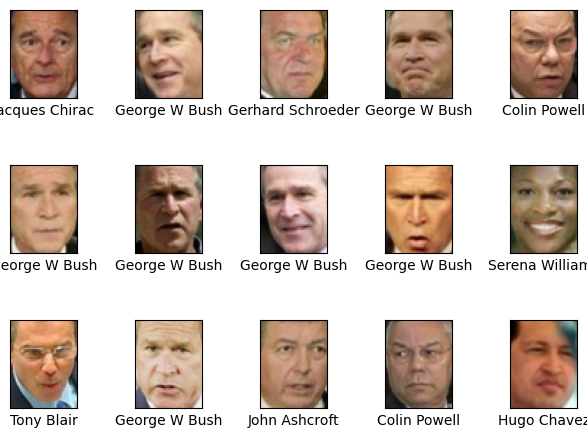

In [ ]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

plt.show()

# Preprocessing

In [ ]:
'''
    Pada bagian ini Anda diperbolehkan untuk melakukan proses pra pengolahan data (preprocessing) sesuai dengan kebutuhan. Pra pengolahan data dapat berupa,

    1. Standardisasi nilai fitur ataupun label
    2. Penyesuaian ukuran gambar
    3. Perubahan colorspace gambar
    4. dsb
'''
def resize_image(image, size=(100,100)):
    resized_img = cv.resize(image, size, interpolation=cv.INTER_AREA)
    return resized_img

def colorspace_image(image, colorspace='RGB'):
    if colorspace == 'GRAY':
        converted_img = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    elif colorspace == 'HSV':
        converted_img = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    elif colorspace == 'LAB':
        converted_img = cv.cvtColor(image, cv.COLOR_RGB2LAB)
    else:
        converted_img = image

    return converted_img

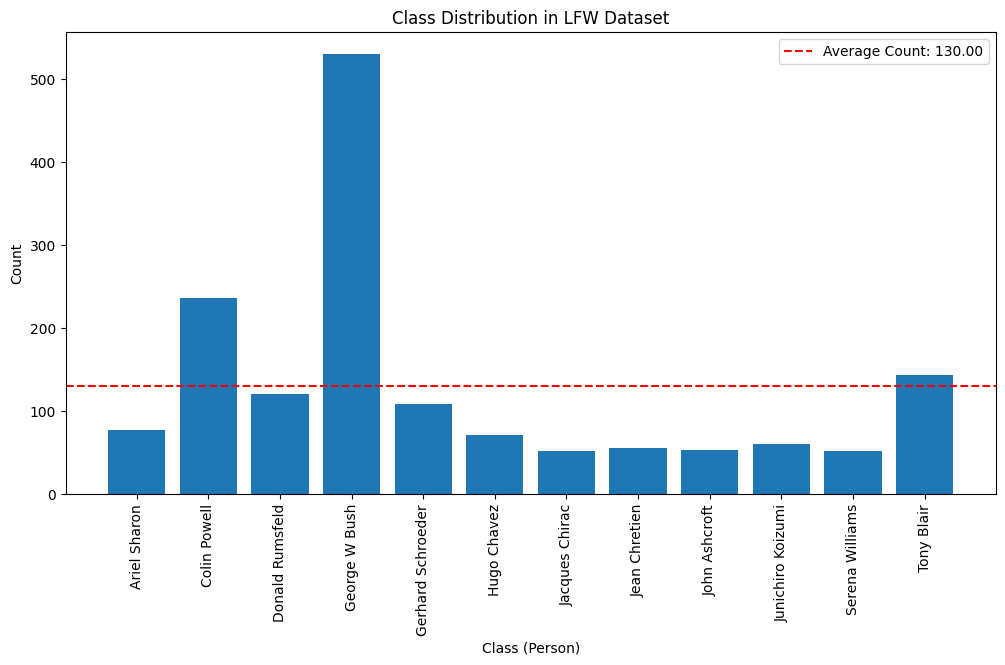

In [ ]:
y = faces.target
# penjelasan:
# variabel y digunakan untuk menyimpan lebel untuk target dari LFW yang mempresentasikan indeks identitas unik orang orang dalam dataset

class_distribution = np.bincount(y)
# penjelasan:
# baris ini menghitung jumlah kemunculan setiap label. Fungsi np.bincount(y) menghasilkan array di mana setiap elemen merepresentasikan berapa kali sebuah label muncul (yaitu, berapa banyak gambar yang dimiliki oleh setiap orang).

plt.figure(figsize=(12, 6))
plt.bar(range(len(faces.target_names)), class_distribution, tick_label=faces.target_names)
plt.xticks(rotation=90)
plt.xlabel('Class (Person)')
plt.ylabel('Count')
plt.title('Class Distribution in LFW Dataset')

# penjelasan:
# Fungsi plt.bar() digunakan untuk membuat grafik batang yang menggambarkan distribusi kelas. Sumbu x diisi dengan nama-nama orang (faces.target_names), dan tinggi batang (y-axis) menunjukkan jumlah gambar per orang, yang diambil dari class_distribution.
# fungsi xtucks() untuk memutar lebel sumbu x agar mudah dibaca

average_count = np.mean(class_distribution)
plt.axhline(y=average_count, color='r', linestyle='--', label=f'Average Count: {average_count:.2f}')
# penjelasan:
# average_count = np.mean(class_distribution): Menghitung rata-rata jumlah gambar per kelas dengan menggunakan fungsi np.mean() pada class_distribution.
# plt.axhline(y=average_count, color='r', linestyle='--', label=f'Average Count: {average_count:.2f}'): Menambahkan garis horizontal pada plot di posisi rata-rata jumlah gambar per kelas (average_count). Garis ini berwarna merah (color='r') dan menggunakan gaya garis putus-putus (linestyle='--'). Label dari garis tersebut juga menunjukkan nilai rata-rata yang telah dihitung dengan dua angka di belakang koma.

# untuk menampilkan label untuk garis rata rata
plt.legend()

plt.show()

Dari visualisasi distribusi kelas di dataset LFW yang ditampilkan, tampak bahwa dataset tersebut sangat tidak seimbang. Beberapa kelas (orang) memiliki jumlah gambar yang sangat banyak, sementara sebagian besar lainnya memiliki jumlah gambar yang sangat sedikit. Distribusi ini menandakan adanya class imbalance, yang bisa memengaruhi performa model machine learning, terutama model berbasis klasifikasi.

# Features Extraction

In [ ]:
'''
    Pada bagian ini, lakukan proses ekstraksi fitur yang diminta, yaitu histogram tiap channel.
    Terdapat banyak cara untuk melakukan ekstraksi fitur histrogram.

    Hints:
        Salah satu cara untuk melakukan ekstraksi fitur histrogram adalah,
        Anda dapat menggunakan fungsi np.histrogram dari library numpy
'''

def extract_histogram(image, colorspace, grid_size=(8, 8)):
    h, w, _ = image.shape
    grid_h, grid_w = h // grid_size[0], w // grid_size[1]
    features = []

    for i in range(0, h, grid_h):
        for j in range(0, w, grid_w):
            grid = image[i:i + grid_h, j:j + grid_w]

            if colorspace == 'GRAY':
                gray_grid = cv.cvtColor(grid, cv.COLOR_RGB2GRAY)
                hist = np.histogram(gray_grid)[0]
                hist = hist.astype('float')
                hist /= (np.sum(hist) + 1e-6)
                features.extend(hist)
            else:
                channels = cv.split(grid)
                for channel in channels:
                    hist = np.histogram(channel)[0]
                    hist = hist.astype('float')
                    hist /= (np.sum(hist) + 1e-6)
                    features.extend(hist)

    return np.array(features)


In [ ]:
size = (75, 75)
colorspace = 'RGB'
resize_images = []
colorspace_images = []
X_histograms = []

for image in faces.images:
    resized_img = resize_image(image, size)
    resize_images.append(resized_img)

for image in resize_images:
    converted_img = colorspace_image(image, colorspace)
    colorspace_images.append(converted_img)

for image in colorspace_images:
    hist = extract_histogram(image, colorspace)
    X_histograms.append(hist)

# Build Model

In [ ]:
'''
    Pada bagian ini lakukan proses pembuatan model,

    1. Pembuatan data training dan data testing
    2. Pembuatan objek model
    3. Proses fitting model
'''

X_train, X_test, y_train, y_test = train_test_split(X_histograms, faces.target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train_scaled, y_train)

SVC(C=1, kernel='linear')

# Evaluation

Data Training Accuracy: 1.00
Data Test Accuracy: 0.74
Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.60      0.55      0.57        11
     Colin Powell       0.77      0.87      0.82        55
  Donald Rumsfeld       0.67      0.64      0.65        25
    George W Bush       0.76      0.91      0.83       107
Gerhard Schroeder       0.71      0.48      0.57        21
      Hugo Chavez       0.78      0.50      0.61        14
   Jacques Chirac       1.00      0.29      0.44         7
    Jean Chretien       0.60      0.25      0.35        12
    John Ashcroft       0.90      0.75      0.82        12
Junichiro Koizumi       0.75      0.75      0.75         8
  Serena Williams       0.50      0.71      0.59         7
       Tony Blair       0.70      0.64      0.67        33

         accuracy                           0.74       312
        macro avg       0.73      0.61      0.64       312
     weighted avg       0.74      0.

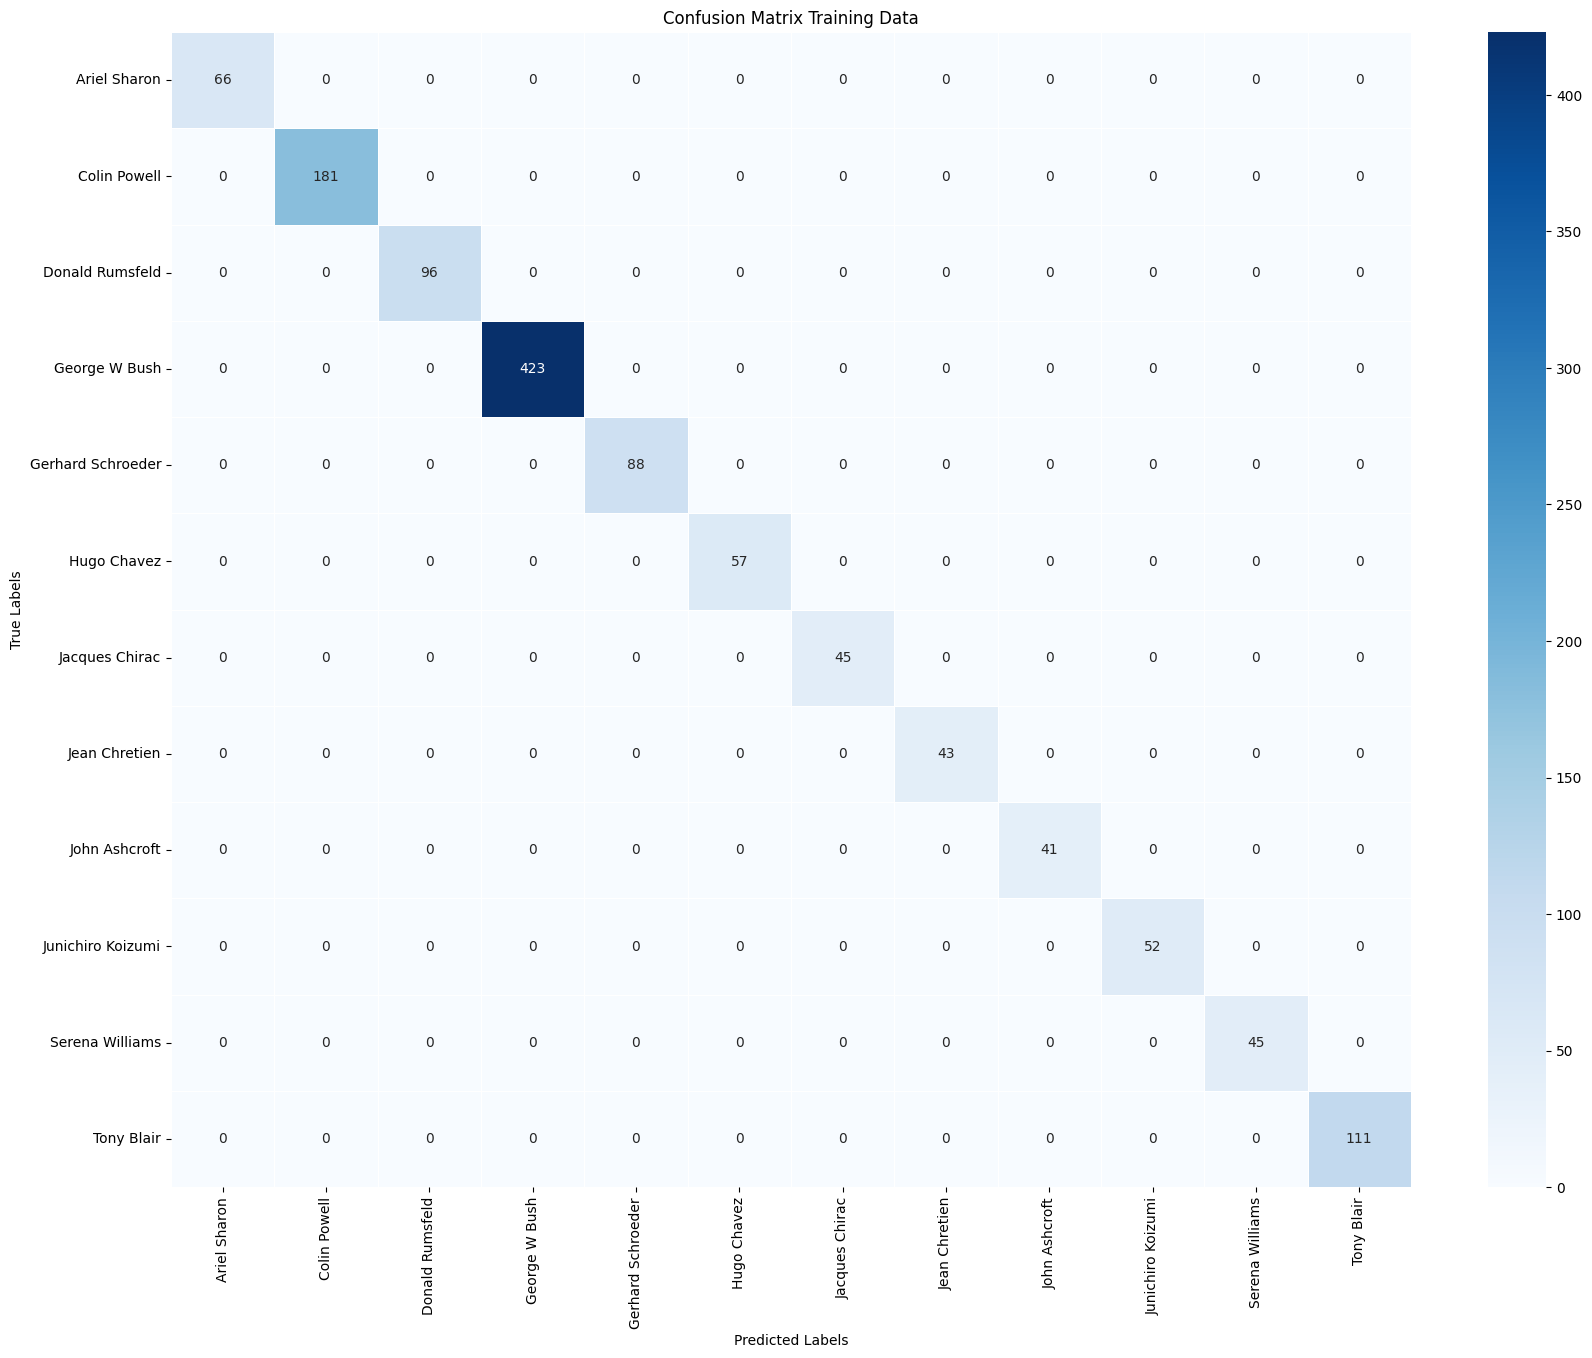

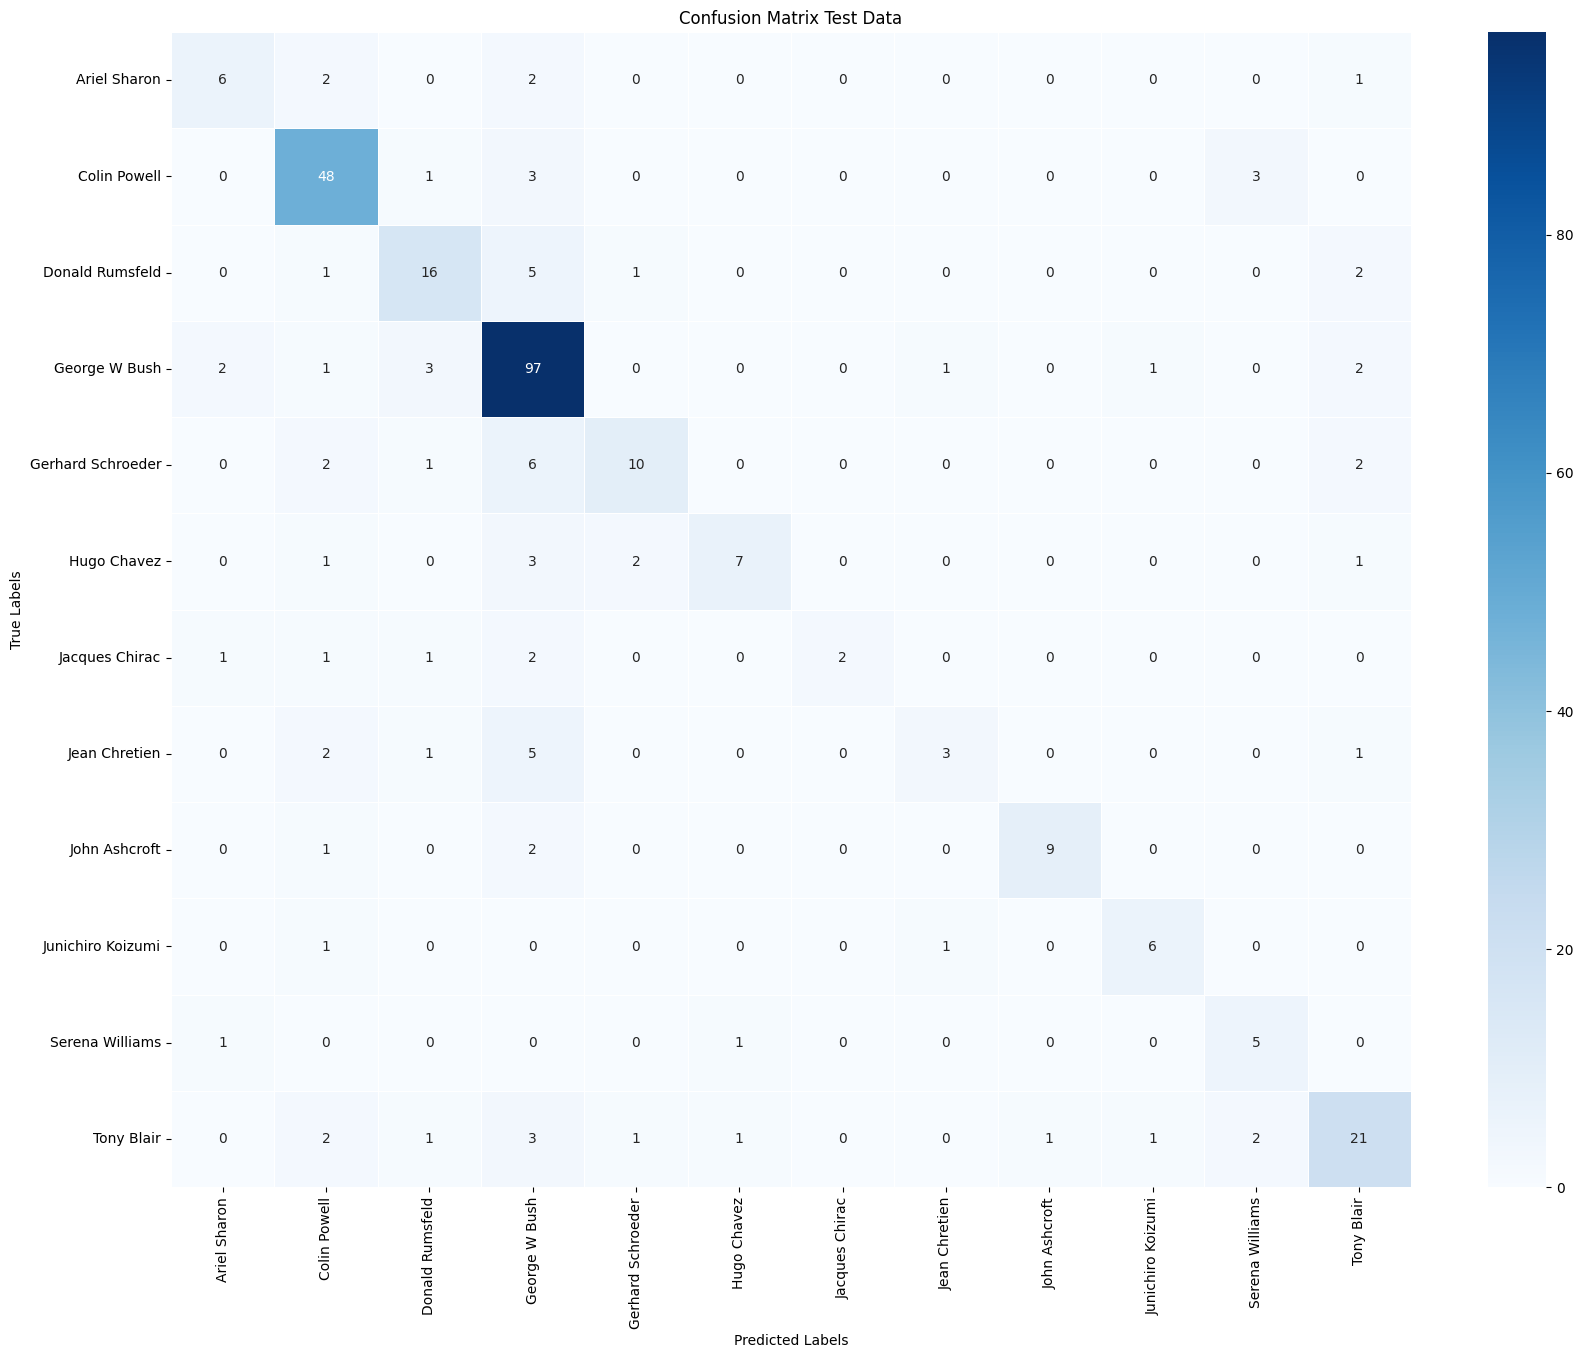

In [ ]:
'''
    Pada bagian ini, lakukan evaluasi terhadap data training dan data testing
    dengan menggunakan metric akurasi dan juga classfication report

    Hints:
        Anda dapat menggunakan referensi Jobseet 4 Percobaan 5
'''

y_train_pred = svm_model.predict(X_train_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Data Training Accuracy: {train_accuracy:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Data Test Accuracy: {test_accuracy:.2f}")

labels = np.unique(faces.target)
target_names = faces.target_names[labels]

print("Classification Report:")
print(classification_report(y_test, y_test_pred, labels=labels, target_names=target_names))

# confusion matrix visualization
def plot_confusion_matrix(cm, target_names, name='Confusion Matrix'):
    plt.figure(figsize=(20, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names, linewidths=0.5)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{name}')
    plt.show()

# Tampilkan Confusion Matrix
cm_svm_train = confusion_matrix(y_train, y_train_pred)
cm_svm_test = confusion_matrix(y_test, y_test_pred)

plot_confusion_matrix(cm_svm_train, faces.target_names, name='Confusion Matrix Training Data')
plot_confusion_matrix(cm_svm_test, faces.target_names, name='Confusion Matrix Test Data')

Hasil dari percobaan dan model kali ini dapat dilihat bahwa.

Hasil `Training Accuracy` sebesar 1.00 (100%) menandakan bahwa model mempelajari data pelatihan dengan sempurna. Ini menunjukkan bahwa model sangat baik dalam mengenali pola pada data pelatihan.
sedangkan hasil `Test Accuracy` sebesar 0.74 (74%) menunjukkan bahwa performa model pada data yang belum dilihat (data uji) tidak setinggi di data pelatihan.

di situasi ini model sangat baik pada data pelatihan tetapi gagal menggeneralisasi dengan baik pada data baru (data uji). Model "menghafal" data training, tetapi tidak dapat menangani variasi yang ada pada data uji. Berdasarkan perbedaan besar antara training dan test accuracy, model mengalami overfitting.

Classification report memberikan informasi lebih mendetail tentang kinerja model per kelas, berdasarkan metrik berikut:

- Precision: Persentase prediksi positif yang benar.
- Recall: Persentase true positive yang ditemukan oleh model dari total data aktual.
-F1-Score: Harmonik rata-rata antara precision dan recall. Semakin mendekati 1, semakin baik.
- Support: Jumlah sampel per kelas.

Beberapa contoh dari hasil:

  - Colin Powell:

    Precision: 0.77 (Dari seluruh prediksi Colin Powell, 77% benar)

    Recall: 0.87 (Dari seluruh gambar Colin Powell yang benar, 87% terdeteksi)
    
    F1-Score: 0.82 (Keseimbangan antara precision dan recall cukup baik)
  
  - George W Bush:

    Precision: 0.76,
    
    Recall: 0.91,
    
    F1-Score: 0.83.
    
    Model sangat baik dalam mendeteksi George W Bush.

Penjelasan confusion matrix:

- True Positive (TP): Prediksi benar terhadap kelas positif.
- False Positive (FP): Prediksi salah, di mana model memprediksi kelas positif, tetapi sebenarnya negatif (biasanya disebut type I error).
- True Negative (TN): Prediksi benar terhadap kelas negatif.
- False Negative (FN): Prediksi salah, di mana model memprediksi negatif tetapi sebenarnya positif (type II error).

**Interpretasi Hasil Klasifikasi Terhadap Permasalahan**

Dengan akurasi 74% pada data uji, model cukup baik dalam mengenali gambar wajah, tetapi memiliki kelemahan di beberapa kelas, seperti Jacques Chirac, Jean Chretien, dan Serena Williams, yang memiliki precision atau recall rendah. Ini menunjukkan bahwa model kesulitan mengenali gambar dengan jumlah sampel kecil atau gambar yang lebih bervariasi dalam dataset.

Ketidakseimbangan dalam performa antar kelas bisa disebabkan oleh ketidakseimbangan jumlah sampel antar kelas di dataset. Sebagai contoh, kelas seperti George W Bush memiliki performa lebih baik daripada Jacques Chirac.

# Other Method and Model

## Extract Using Histogram of Oriented Gradient (HOG)

In [ ]:
def extract_hog(image, colorspace):
    if colorspace == 'GRAY':
        hog_features, _ = hog(image, orientations=9, pixels_per_cell=(4, 4),
                              cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
        return hog_features

    else:
        channels = cv.split(image)
        hog_features = []

        for channel in channels:
            features, _ = hog(channel, orientations=9, pixels_per_cell=(4, 4),
                              cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
            hog_features.append(features)

        return np.concatenate(hog_features)

X_hog = []

for image in colorspace_images:
    hog_features = extract_hog(image, colorspace)
    X_hog.append(hog_features)

## Model K-Nearest Neighbors (KNN)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_hog, faces.target, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Data Training Accuracy: 0.87
Data Test Accuracy: 0.84
Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.82      0.82        11
     Colin Powell       0.87      0.98      0.92        55
  Donald Rumsfeld       0.88      0.88      0.88        25
    George W Bush       0.79      0.97      0.87       107
Gerhard Schroeder       0.63      0.81      0.71        21
      Hugo Chavez       1.00      0.21      0.35        14
   Jacques Chirac       1.00      0.57      0.73         7
    Jean Chretien       1.00      0.42      0.59        12
    John Ashcroft       1.00      0.58      0.74        12
Junichiro Koizumi       1.00      0.75      0.86         8
  Serena Williams       1.00      0.57      0.73         7
       Tony Blair       0.96      0.79      0.87        33

         accuracy                           0.84       312
        macro avg       0.91      0.70      0.75       312
     weighted avg       0.86      0.

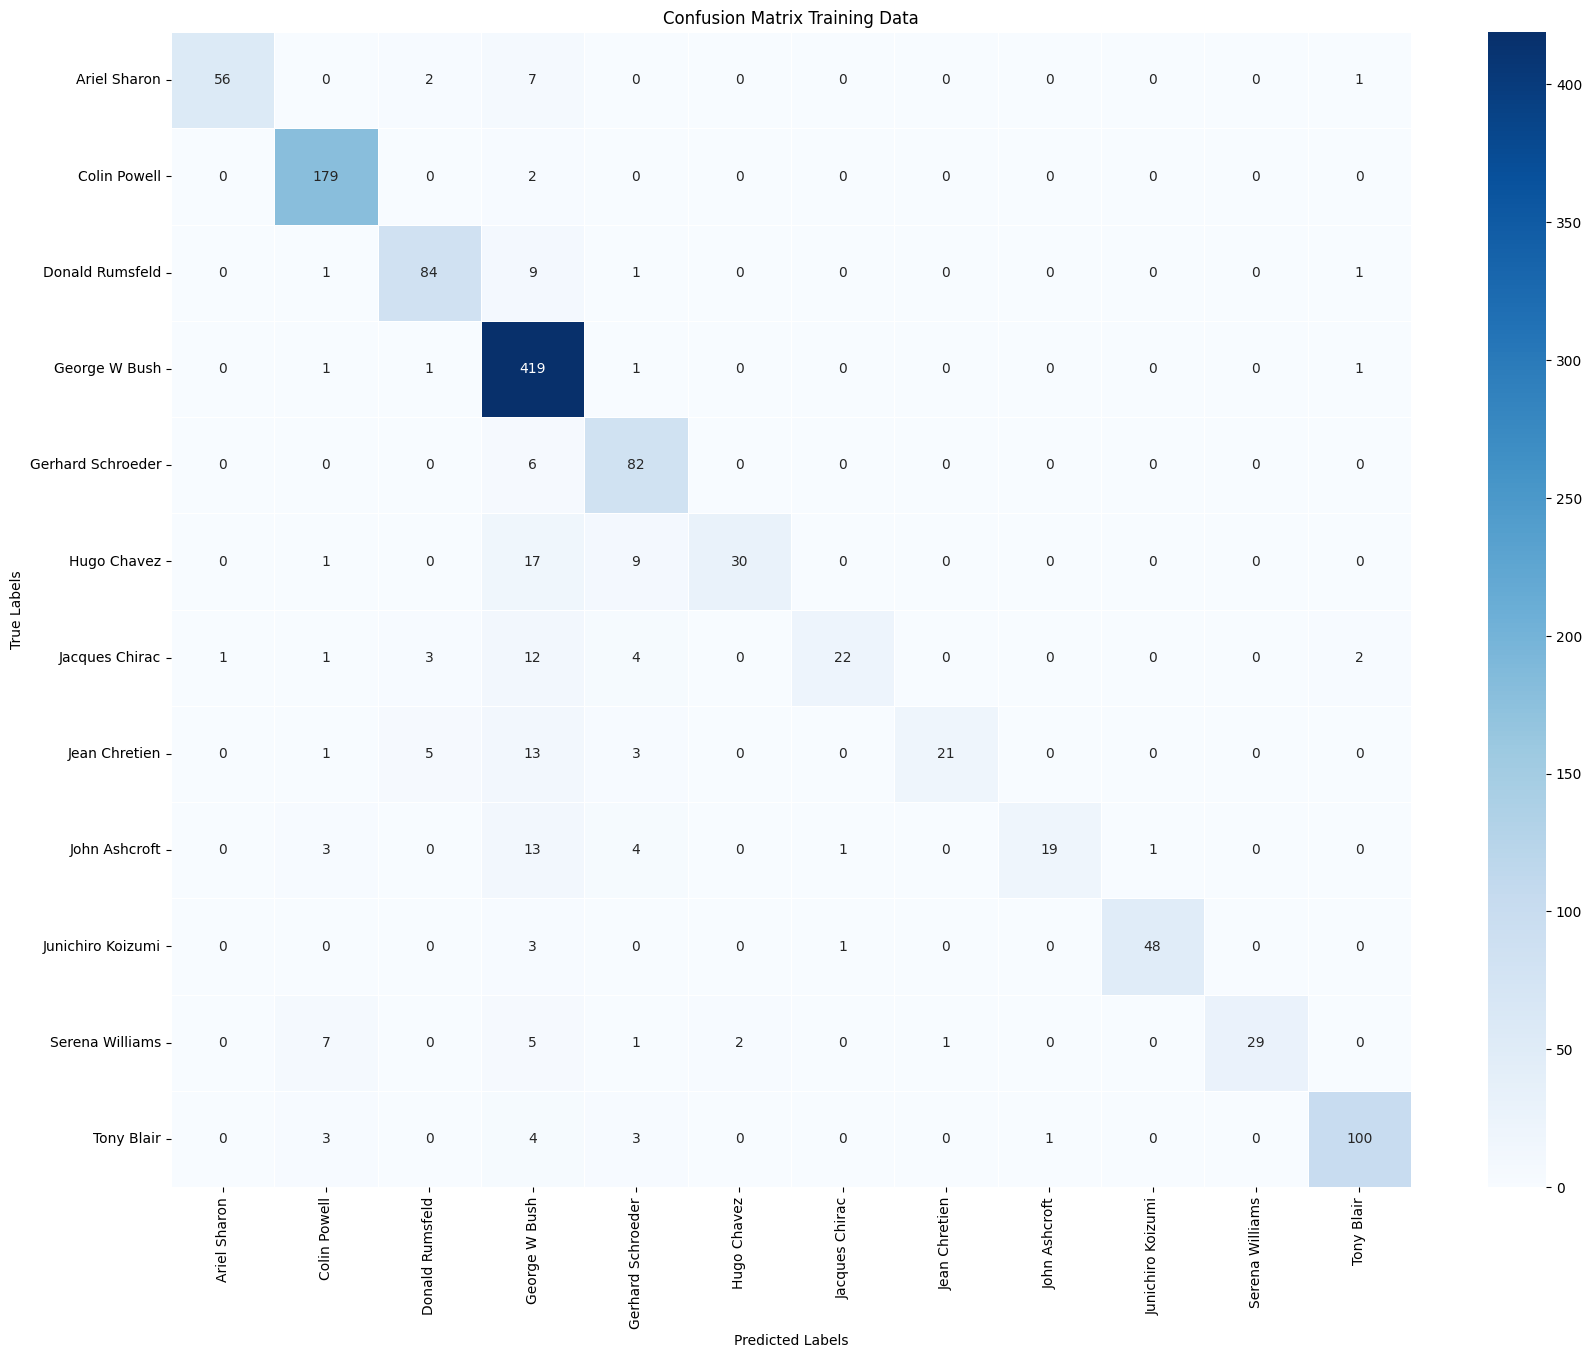

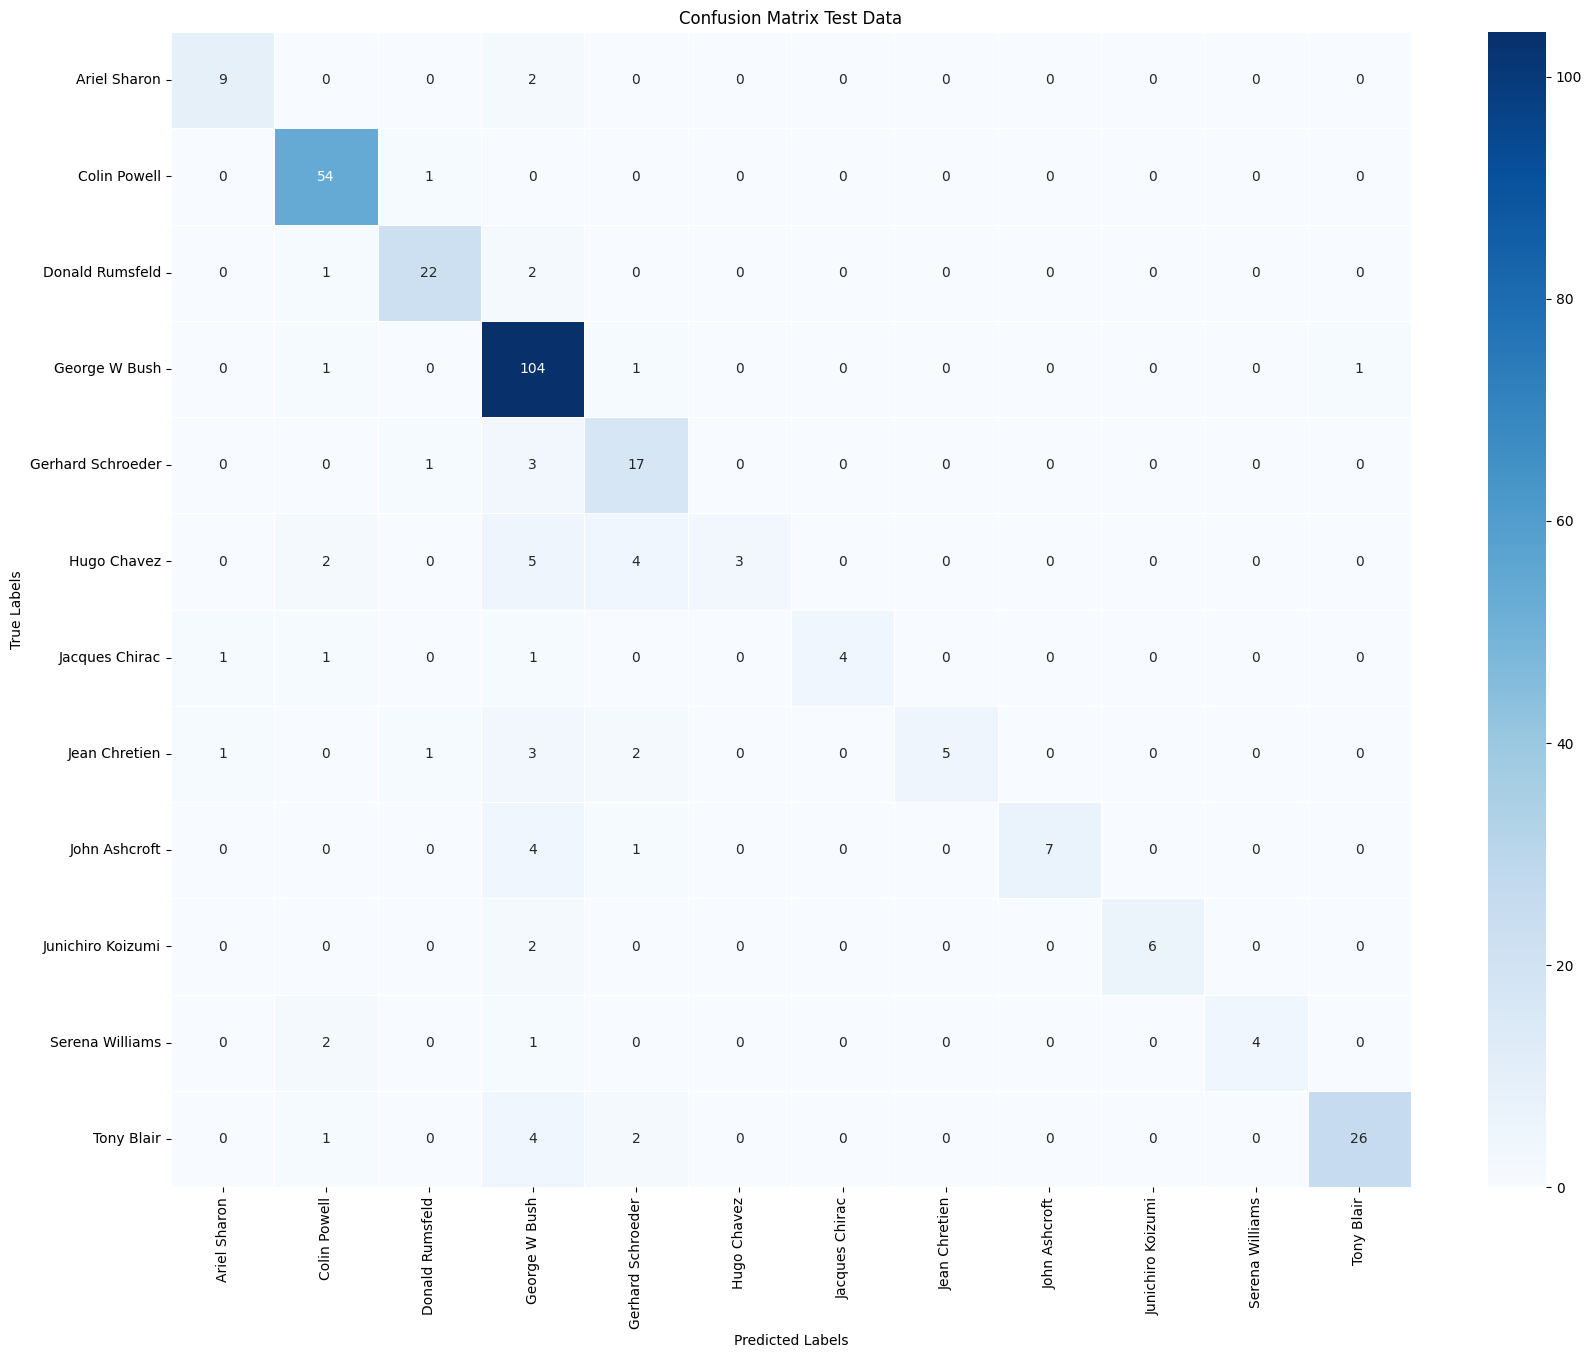

In [ ]:
y_train_pred = knn_model.predict(X_train_scaled)
y_test_pred = knn_model.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Data Training Accuracy: {train_accuracy:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Data Test Accuracy: {test_accuracy:.2f}")

labels = np.unique(faces.target)
target_names = faces.target_names[labels]

print("Classification Report:")
print(classification_report(y_test, y_test_pred, labels=labels, target_names=target_names))

# confusion matrix visualization
cm_knn_train = confusion_matrix(y_train, y_train_pred)
cm_knn_test = confusion_matrix(y_test, y_test_pred)

plot_confusion_matrix(cm_knn_train, faces.target_names, name='Confusion Matrix Training Data')
plot_confusion_matrix(cm_knn_test, faces.target_names, name='Confusion Matrix Test Data')

Jika kita bandingkan dengan hasil sebelumnya, ada beberapa peningkatan yang signifikan:

- Peningkatan Akurasi:
  
  Baik training accuracy maupun test accuracy mengalami peningkatan yang cukup baik. Ini mengindikasikan model telah belajar lebih baik dari data pelatihan dan mampu menggeneralisasi lebih baik ke data yang belum pernah dilihat.
- Penurunan Overfitting:

  Selisih antara training accuracy dan test accuracy menjadi lebih kecil, menunjukkan bahwa masalah overfitting yang sebelumnya cukup parah telah berkurang secara signifikan. Model ini sekarang lebih mampu menangkap pola umum dalam data tanpa terlalu menghafal detail spesifik dari data pelatihan.

Analisis Mendalam berdasarkan Classification Report:

- Peningkatan Precision dan Recall:

  Secara umum, baik precision maupun recall untuk sebagian besar kelas mengalami peningkatan. Ini berarti model lebih akurat dalam mengidentifikasi kelas yang benar dan lebih sedikit melakukan kesalahan jenis I (false positive) dan jenis II (false negative).

- Perbaikan pada Kelas yang Sebelumnya Sulit:

  Kelas-kelas seperti Jacques Chirac, Jean Chretien, dan Serena Williams yang sebelumnya memiliki performa buruk, sekarang menunjukkan peningkatan yang cukup signifikan. Ini mengindikasikan bahwa model telah belajar untuk mengenali variasi dalam data yang lebih baik.

- Kelas Hugo Chavez:

  Meskipun precision-nya sempurna (1.00), recall-nya sangat rendah (0.21). Ini mengindikasikan bahwa model seringkali gagal mengidentifikasi kelas Hugo Chavez, walaupun ketika berhasil mengidentifikasi, prediksinya selalu benar. Kemungkinan penyebabnya adalah jumlah sampel untuk kelas ini yang masih sangat sedikit atau karakteristik wajah Hugo Chavez yang sangat unik dan sulit dibedakan dari kelas lainnya.


**Performa model**
1. Model sekarang lebih seimbang antara precision, recall, dan akurasi di berbagai kelas, tetapi masih ada beberapa kelas yang memiliki recall rendah, seperti Hugo Chavez. Hal ini bisa menunjukkan bahwa dataset masih kurang mencakup variasi wajah untuk beberapa kelas, atau kelas ini memiliki fitur visual yang sulit dikenali oleh model.

2. Precision yang tinggi dan recall yang rendah pada beberapa kelas (seperti John Ashcroft dan Serena Williams) menunjukkan bahwa model cenderung tidak sering memprediksi kelas tersebut, tetapi saat melakukannya, prediksi biasanya benar. Ini bisa disebabkan oleh distribusi yang tidak seimbang dalam data atau kurangnya variasi dalam gambar.

# catatan perbaikan
Seperti yang disebutkan sebelumnya bahwa terjadi ketidak seimbangan class pada dataset yang sangat mempengaruhi machine learning dalam hal klasifikasinya.

berapa langkah yang sempat terfikirkan oleh kami namun belum sempat kami improve untuk mengatasi hal tersebut.

1. Oversampling
2. Undersampling
3. Class Weight
4. Augmentasi data